In [2]:
!export CUDA_LAUNCH_BLOCKING=1

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import numpy as np
import pandas as pd
import re
import collections
import math
import time
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import torchtext
from torchtext.vocab import build_vocab_from_iterator, GloVe, vocab
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, SubsetRandomSampler
from pytorch_lightning.callbacks import TQDMProgressBar
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks.progress import RichProgressBar
from pytorch_lightning.loggers import CSVLogger
from torchmetrics.text.rouge import ROUGEScore

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data loading, EDA, preprocessing

In [5]:
data = pd.read_csv('/content/data/amazon-reviews/Reviews.csv')
data = data.iloc[:100000] # 60000
data = data.dropna()
print('data len:', len(data))
data.head()

data len: 99992


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


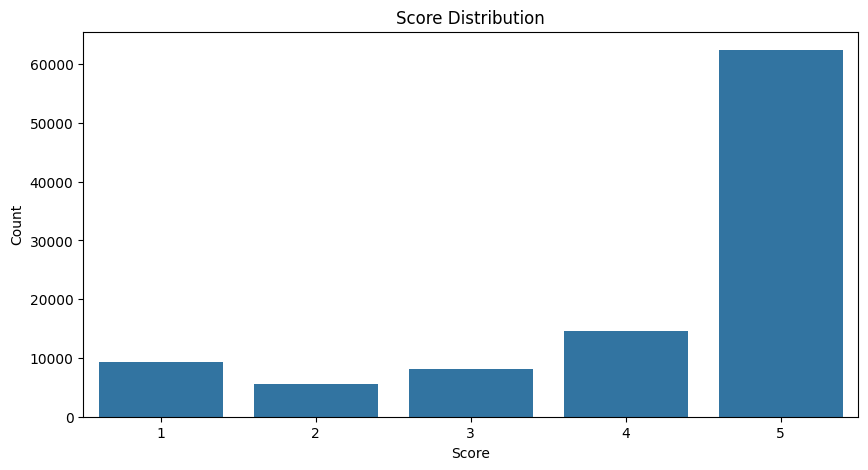

In [6]:
def get_score_distribution(df):
    score_counts = df['Score'].value_counts().sort_index()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=score_counts.index, y=score_counts.values)
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.title('Score Distribution')
    plt.show()

def most_common_words_plot(tokens, word_subset, n=10):
    tokens = [word for sentence in tokens for word in sentence]
    stop_words = set(stopwords.words('english'))
    punkt = set(string.punctuation)
    tokens = [word for word in tokens if word not in stop_words and word not in punkt]
    word_counts = collections.Counter(tokens)
    most_common = word_counts.most_common(n)
    words, counts = zip(*most_common)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=words, y=counts)
    plt.xlabel('Word')
    plt.ylabel('Count')
    plt.title(f'Most Common {word_subset} Words (Top {n})')
    plt.xticks(rotation=45)
    plt.show()

def plot_length_distribution(df, col):
    lengths = df[col].apply(lambda x: len(x.split()))
    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, kde=True)
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.title(f'Length Distribution of {col}')
    plt.show()

get_score_distribution(data)

In [7]:
# Tokenize Summary and Text cols
x = data['Text'].apply(lambda x: word_tokenize(x))
y = data['Summary'].apply(lambda x: word_tokenize(x))

print('x')
print(x.head())
print()
print('y')
print(y.head())

x
0    [I, have, bought, several, of, the, Vitality, ...
1    [Product, arrived, labeled, as, Jumbo, Salted,...
2    [This, is, a, confection, that, has, been, aro...
3    [If, you, are, looking, for, the, secret, ingr...
4    [Great, taffy, at, a, great, price, ., There, ...
Name: Text, dtype: object

y
0          [Good, Quality, Dog, Food]
1               [Not, as, Advertised]
2    [``, Delight, '', says, it, all]
3                   [Cough, Medicine]
4                      [Great, taffy]
Name: Summary, dtype: object


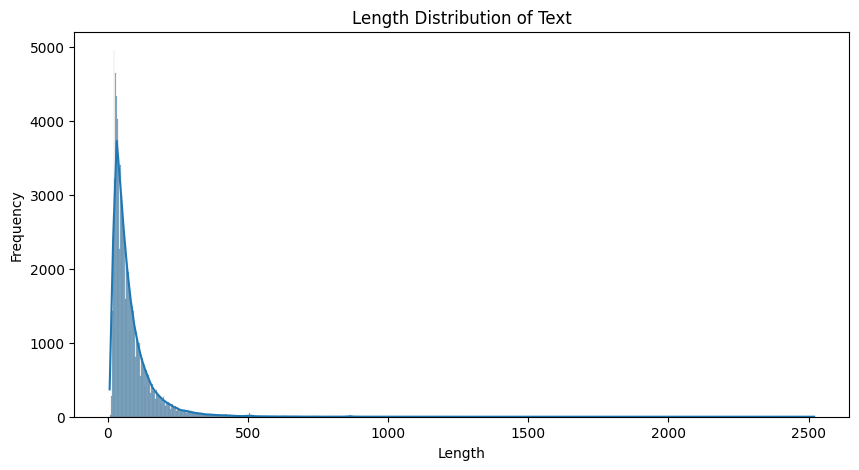

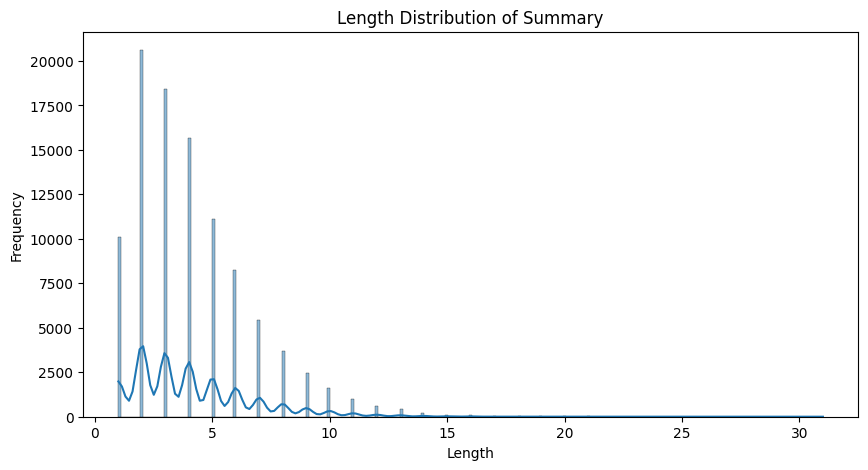

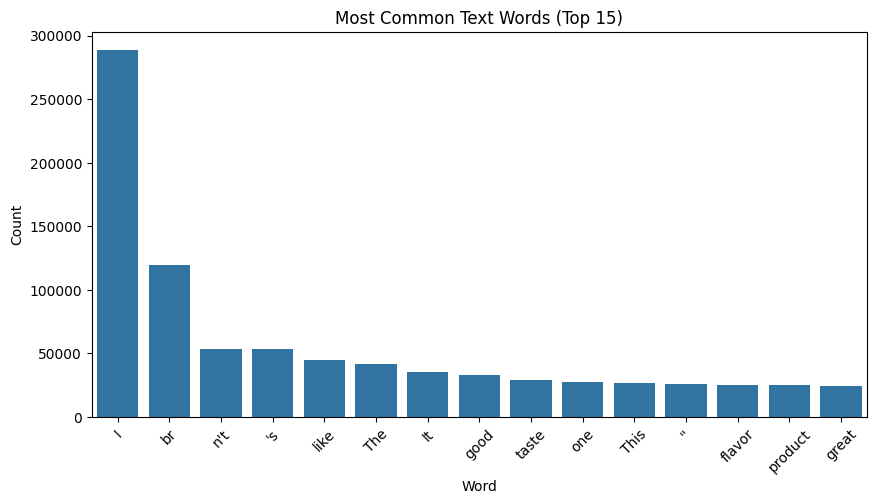

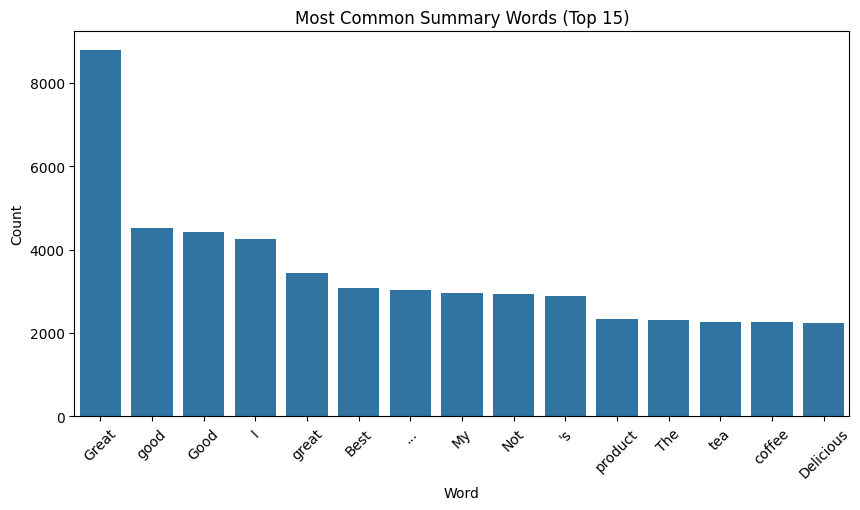

In [8]:
plot_length_distribution(data, 'Text')
plot_length_distribution(data, 'Summary')
most_common_words_plot(x, 'Text', n=15)
most_common_words_plot(y, 'Summary', n=15)

### Clean the data

In [9]:
chat_words_dict = {
    "imo": "in my opinion",
     "cyaa": "see you",
    "idk": "i don't know",
    "rn": "right now",
    "afaik": "as far as I know",
    "asap": "as soon as possible",
    "b4": "before",
    "brb": "be right back",
    "btw": "by the way",
    "dm": "direct message",
    "fyi": "for your information",
    "gtg": "got to go",
    "idc": "i don't care"
}

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def clear_data(text):
    text = text.lower()
    text = decontracted(text)
    text = ' '.join([chat_words_dict[word] if word in chat_words_dict else word for word in text.split()])
    text = re.sub(r'\bbr\b', '', text)
    text = re.sub(r'[^a-z]|\s+', ' ', text)
    text = text.strip()
    return text


In [10]:
data_clean = data.copy()
data_clean = data_clean.dropna()
data_clean = data_clean[data_clean['Text'].apply(lambda x: len(x.split()) <= 200)] # Drop rows where text is longer than 200 tokens
data_clean = data_clean.drop_duplicates(subset=['Text'])
data_clean['Summary'] = data_clean['Summary'].apply(clear_data)
data_clean['Text'] = data_clean['Text'].apply(clear_data)

print('data len:', len(data_clean))

data_clean.head()

data len: 82836


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,good quality dog food,i have bought several of the vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,not as advertised,product arrived labeled as jumbo salted peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,delight says it all,this is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,cough medicine,if you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,great taffy,great taffy at a great price there was a wide...


In [11]:
# Tokenize Summary and Text cols
x = data_clean['Text'].apply(word_tokenize)
y = data_clean['Summary'].apply(word_tokenize)

print('x')
print(x.head())
print()
print('y')
print(y.head())

x
0    [i, have, bought, several, of, the, vitality, ...
1    [product, arrived, labeled, as, jumbo, salted,...
2    [this, is, a, confection, that, has, been, aro...
3    [if, you, are, looking, for, the, secret, ingr...
4    [great, taffy, at, a, great, price, there, was...
Name: Text, dtype: object

y
0    [good, quality, dog, food]
1         [not, as, advertised]
2      [delight, says, it, all]
3             [cough, medicine]
4                [great, taffy]
Name: Summary, dtype: object


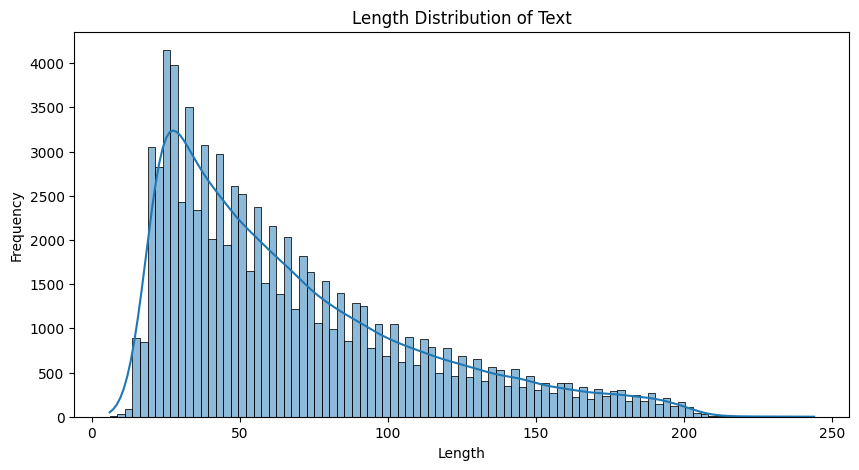

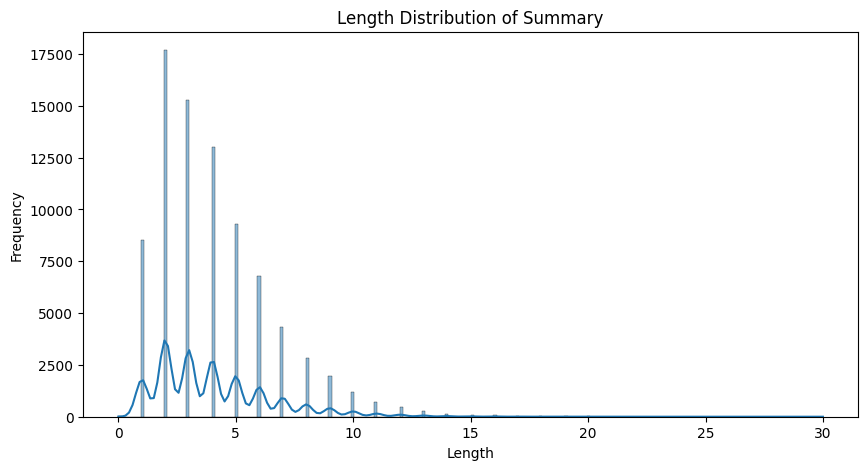

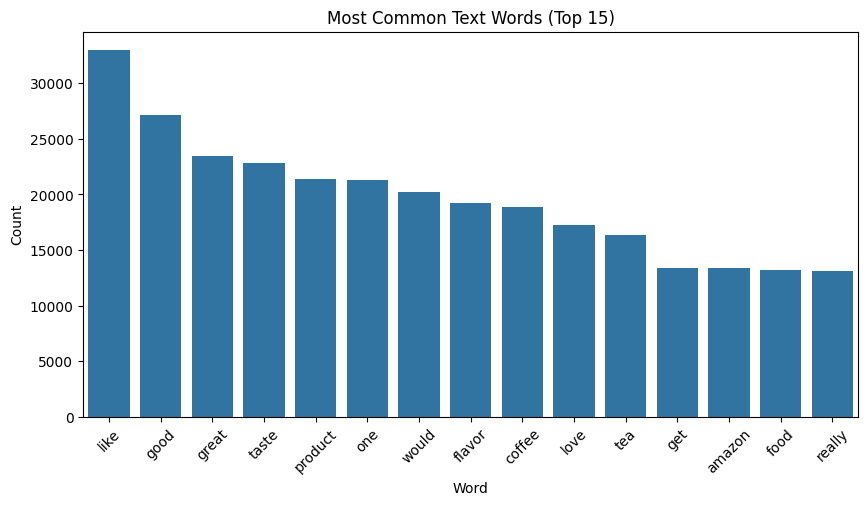

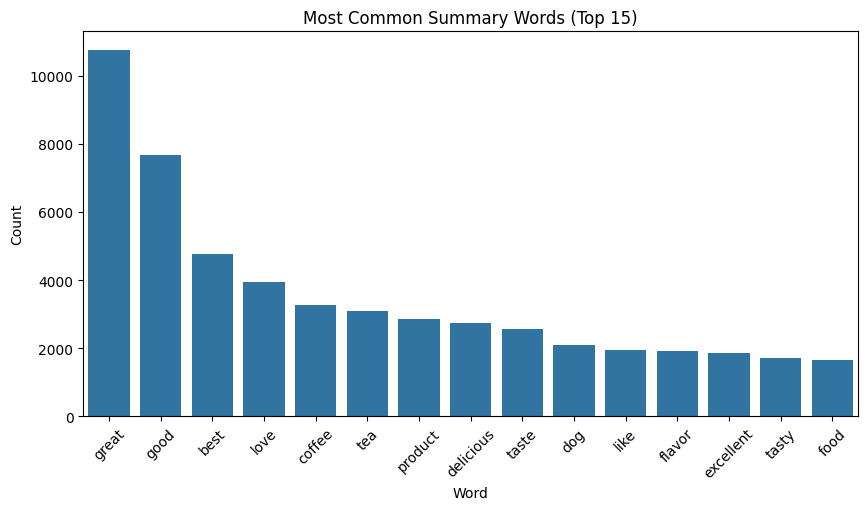

In [12]:
plot_length_distribution(data_clean, 'Text')
plot_length_distribution(data_clean, 'Summary')
most_common_words_plot(x, 'Text', n=15)
most_common_words_plot(y, 'Summary', n=15)

### Data module

In [13]:
def indexes_2_text(indexes, vocab, remove_specials=False):
    tokens = [vocab.get_itos()[i] for i in indexes]

    if remove_specials:
        tokens = [token for token in tokens if token not in [SOS, EOS, PAD, UNK]]

    text = ' '.join(tokens)

    return text


In [14]:
UNK = '<unk>'
PAD = '<pad>'
SOS = '<sos>'
EOS = '<eos>'
UNK_IDX = 0
PAD_IDX = 1
SOS_IDX = 2
EOS_IDX = 3

TEST_SIZE = 0.20

class TextDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['Text']
        summary = self.df.iloc[idx]['Summary']
        return text, summary

class TextDataModule(pl.LightningDataModule):
    def __init__(self, df, embedding=None, batch_size=32, num_workers=1):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.df = df

        self.text_tokenizer = word_tokenize

        self.vocab = self.build_vocab(pd.concat((self.df['Text'], self.df['Summary']), axis=0))

        self.vocab_size = len(self.vocab)

    def build_vocab(self, texts):
        token_generator = (self.text_tokenizer(text) for text in texts)
        _vocab = build_vocab_from_iterator(token_generator, specials=[UNK, PAD, SOS, EOS], special_first=True)
        _vocab.set_default_index(_vocab[UNK])
        print(f'Vocab size: {len(_vocab)}')
        # print(f'Vocab: {vocab.get_itos()}')
        return _vocab

    def setup(self, stage=None):
        train_df, test_df = train_test_split(self.df, test_size=TEST_SIZE, shuffle=True)
        self.train_dataset = TextDataset(train_df)
        self.val_dataset = TextDataset(test_df)

    def _append_special_tokens(self, tokens):
        return [SOS] + tokens + [EOS]

    def _collate_batch(self, batch):
        texts, summaries = zip(*batch)

        tokenized_texts = [self.text_tokenizer(text) for text in texts]
        tokenized_summaries = [self.text_tokenizer(summary) for summary in summaries]

        tokenized_texts = [self._append_special_tokens(text) for text in tokenized_texts]
        tokenized_summaries = [self._append_special_tokens(summary) for summary in tokenized_summaries]

        inputs = [torch.tensor(self.vocab(tokens), dtype=torch.long) for tokens in tokenized_texts]
        inputs = pad_sequence(inputs, batch_first=True, padding_value=PAD_IDX)

        targets = [torch.tensor(self.vocab(tokens)) for tokens in tokenized_summaries]
        targets = pad_sequence(targets, batch_first=True, padding_value=PAD_IDX)

        return inputs, targets

    def collate_fn(self, batch):
        return self._collate_batch(batch)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
            num_workers=self.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
            num_workers=self.num_workers
        )

    def predict_dataloader(self):
        return DataLoader(
            Subset(self.val_dataset, range(40)),
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
            num_workers=self.num_workers
        )

In [15]:
data_module = TextDataModule(data_clean, batch_size=96, num_workers=2)
data_module.setup()
basic_vocab_size = data_module.vocab_size
basic_vocab = data_module.vocab

text_batch_sample, summary_batch_sample = next(iter(data_module.train_dataloader()))
print('text batch sample shape', text_batch_sample.shape)
print('summary batch sample shape', summary_batch_sample.shape)
print('text batch sample tensor:', text_batch_sample[0])
print('summary batch sample tensor: ', summary_batch_sample[0])
print('text batch sample text: ', indexes_2_text(text_batch_sample[0], basic_vocab))
print('summary batch sample text: ', indexes_2_text(summary_batch_sample[0], basic_vocab))

Vocab size: 47839
text batch sample shape torch.Size([96, 186])
summary batch sample shape torch.Size([96, 13])
text batch sample tensor: tensor([  2,   5,  17,  90,   7, 186, 197, 318,  19,  12,   9,  16, 119,   6,
          8,   9,  72, 191,  29,  66,  59, 211,   8,  40,   4, 287, 132, 204,
        138,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
    

### Seq2Seq Module

In [16]:
class Seq2SeqModel(pl.LightningModule):
    def __init__(self, encoder, decoder, learning_rate, vocab):
        super(Seq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.learning_rate = learning_rate
        self.criterion = nn.NLLLoss(ignore_index=PAD_IDX)
        self.rouge = ROUGEScore(rouge_keys='rougeL', tokenizer=word_tokenize)
        self.vocab = vocab

    def forward(self, input, target):
        # Encoder forward
        encoder_outputs, hidden, _ = self.encoder(input)

        # Decoder forward
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long).fill_(SOS_IDX).to(self.device)

        output, _, _ = self.decoder(decoder_input, encoder_outputs, hidden, target)

        return output

    def shared_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs, targets)

        max_seq_length = inputs.size(1)

        output_pad_size = max_seq_length - outputs.size(1)
        outputs = F.pad(outputs, (0, 0, 0, output_pad_size), mode='constant', value=PAD_IDX)

        targets_pad_size = max_seq_length - targets.size(1)
        targets = F.pad(targets, (0, targets_pad_size), mode='constant', value=PAD_IDX)

        outputs = outputs.view(-1, outputs.size(-1))
        targets = targets.view(-1)
        loss = self.criterion(outputs.view(-1, outputs.shape[-1]), targets.view(-1))

        return loss


    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def predict_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs, targets)
        inputs_as_text = [indexes_2_text(input, data_module.vocab, remove_specials=True) for input in inputs]
        targets_as_text = [indexes_2_text(target, data_module.vocab, remove_specials=True) for target in targets]

        # Sample the predicted word from the topk
        outputs = torch.exp(outputs) # log softmax to softmax to get positive probs

        outputs = outputs.argmax(dim=-1)
        outputs_as_text = [indexes_2_text(output, data_module.vocab, remove_specials=True) for output in outputs]

        rouge_avg = 0

        for input_text, target_text, output_text in zip(inputs_as_text, targets_as_text, outputs_as_text):
            rouge = self.rouge(output_text, target_text)['rougeL_fmeasure']
            rouge_avg += rouge

            print('----')
            print(f'Input: {input_text}')
            print(f'Target: {target_text}')
            print(f'Output: {output_text}')
            print(f'Rouge: {rouge}')

        rouge_avg /= len(inputs_as_text)
        print(f'Rouge avg: {rouge_avg}')

        return outputs

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate),

## Encoder / decoder (GRU)

In [17]:
class GRUEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers, dropout, embedding=None):
        super(GRUEncoder, self).__init__()
        if embedding is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding, padding_idx=PAD_IDX, freeze=True)
        else:
            self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=PAD_IDX)

        self.gru = nn.GRU(emb_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        outputs, hidden = self.gru(embedded)
        return outputs, hidden, None

class GRUDecoder(nn.Module):
    def __init__(self, emb_dim, hidden_size, output_size, embedding=None, max_length=10):
        super(GRUDecoder, self).__init__()
        if embedding is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding, padding_idx=PAD_IDX, freeze=True)
        else:
          self.embedding = nn.Embedding(output_size, emb_dim, padding_idx=PAD_IDX)

        self.gru = nn.GRU(emb_dim, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.max_length = max_length

    def forward(self, decoder_input, encoder_outputs, encoder_hidden, target_tensor=None):
        decoder_hidden = encoder_hidden[:-1, :, :] # Pick just last layer of the multiple encoder's hidden layers
        decoder_outputs = []

        sequence_size = target_tensor.size(1) if target_tensor is not None else self.max_length

        for i in range(sequence_size):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden


### Training

In [20]:
INPUT_DIM = basic_vocab_size
OUTPUT_DIM = basic_vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 128
ENC_LAYERS = 2
DEC_LAYERS = 3
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 1e-3


encoder = GRUEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_LAYERS, ENC_DROPOUT)
decoder = GRUDecoder(DEC_EMB_DIM, HID_DIM, OUTPUT_DIM)
model = Seq2SeqModel(encoder, decoder, learning_rate=LEARNING_RATE, vocab=data_module.vocab)

#####

PATIENCE = 5
NUM_EPOCHS = 20

early_stopping_cb = EarlyStopping(monitor="val_loss", mode="min", patience=PATIENCE)

logger = CSVLogger(save_dir=f'outputs-bc', name='gru')

trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=[early_stopping_cb, RichProgressBar(refresh_rate=10)],
    accelerator="auto",
    devices="auto",
    logger=logger
)

start_time = time.time()
trainer.fit(model, data_module)
elapsed_time = (time.time() - start_time) / 60
print(f'Training time: {elapsed_time:.2f} minutes')


INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ encoder   │ GRUEncoder │ 12.5 M │ train │
│ 1 │ decoder   │ GRUDecoder │ 18.6 M │ train │
│ 2 │ criterion │ NLLLoss    │      0 │ train │
│ 3 │ rouge     │ ROUGEScore │      0 │ train │
│ 4 │ vocab     │ Vocab      │      0 │ train │
└───┴───────────┴────────────┴────────┴───────┘

Trainable params: 31.1 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 31.1 M                                                                                               
Total estimated model params size (MB): 124                                                                        
Modules in train mode: 11                                                                                          
Modules in eval mode: 0

Output()

Training time: 9.97 minutes


### Evaluation

In [22]:
def plot_metrics(trainer):
  metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

  aggreg_metrics = []
  agg_col = 'epoch'

  for i, dfg in metrics.groupby(agg_col):
      agg = dict(dfg.mean())
      agg[agg_col] = i
      aggreg_metrics.append(agg)

  df = pd.DataFrame(aggreg_metrics)

  # loss
  plt.figure(figsize=(10, 5))
  plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
  plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Over Epochs')
  plt.legend()
  plt.show()

def generate_summary(_model, src, max_len=10):
    with torch.no_grad():
        encoder_outputs, encoder_hidden, _ = _model.encoder(src)
        decoder_input = torch.tensor([[SOS_IDX]], device=_model.device)

        predicted = []

        # decoder_hidden = encoder_hidden[:-1, :, :]
        decoder_hidden = encoder_hidden[:-1, :, :]

        for i in range(max_len):
            decoder_outputs, decoder_hidden = _model.decoder.forward_step(decoder_input, decoder_hidden)

            # print('decoder_outputs.shape', decoder_outputs)

            # topv, topi = decoder_outputs.squeeze(0).topk(50)
            topv, topi = decoder_outputs.topk(1)
            # topi = torch.multinomial(F.softmax(decoder_outputs.squeeze(0), dim=1), 1)
            # topi = torch.multinomial(F.softmax(topv, dim=1), 1)
            decoded_ids = topi.squeeze(0)

            # print('decoded_ids', decoded_ids)

            if decoded_ids.item() == EOS_IDX:
                predicted.append(EOS_IDX)
                break
            else:
              predicted.append(decoded_ids.item())

            # decoder_input = decoded_ids.detach()

    return predicted

def evaluate(_model, _data_module):
  for src, tgt in _data_module.val_dataloader():
    for i in range(len(src)): # iterate through all the batch items
      target_summary = indexes_2_text(tgt[i], data_module.vocab, remove_specials=True)

      print('TEXT: ', indexes_2_text(src[i], data_module.vocab, remove_specials=True))
      print('TARGET:', target_summary)
      print('SUMM:', indexes_2_text(torch.tensor(generate_summary(_model, src[i].unsqueeze(0)), dtype=torch.long), data_module.vocab, remove_specials=True))
      print('----')

# evaluate(model, data_module)

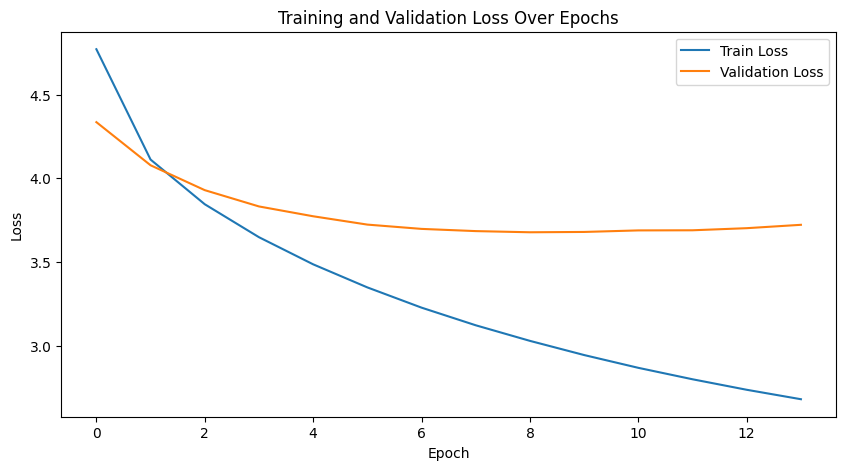

In [23]:
  # rouge
  # plt.figure(figsize=(10, 5))
  # plt.plot(df['epoch'], df['train_rouge'], label='Train Rouge')
  # plt.plot(df['epoch'], df['val_rouge'], label='Validation Rouge')
  # plt.xlabel('Epoch')
  # plt.ylabel('Loss')
  # plt.title('Training and Validation Rouge Over Epochs')
  # plt.legend()
  # plt.show()

plot_metrics(trainer)

In [24]:
trainer.predict(model, data_module, return_predictions=False)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

----

Input: this coconut water is completely disgusting i normally buy brands like o n e and vita coco but it has been 
hard to find them in stock recently i have seen zico so when it went on sale at a local store i decided to try it i
did not take the time to check the ingredients because i assumed it was like the other brands pure coconut water 
first off this is from concentrate they defend this on their website but do not be fooled it affects taste quality 
and nutrition second they add natural flavors there is nothing natural about a natural flavor it tastes fake and 
has a nasty aftertaste this is by far the worst coconut water on the market and i hope they will listen to 
consumers and actually make it natural

Target: far from natural

Output: not too the soda acid donuts sodas sodas sodas sodas

Rouge: 0.0

----

Input: they are not contained in the keurig plastic cup so once you open the package you will want to put them in 
an airtight storage but i was really impressed with the smooth flavor and good taste these were a little cheaper 
than most of the keurig kcups i have found so i was not sure what to expect but these are deff up there on my 
favorites list

Target: love it

Output: good this it or donuts donuts etc etc etc

Rouge: 0.1818181872367859

----

Input: the packing was so poor that the mix had spilled in the packing box when i could get enough to make pancakes
they were very good

Target: red velvet pancake mix

Output: good velvet cake mix flavor amount amount etc etc etc

Rouge: 0.2857142984867096

----

Input: my dog buddy loves this mixed in his food and i love that it is organic i will purchase again

Target: my dog loves this

Output: my dog loves it food etc etc

Rouge: 0.5454545617103577

----

Input: i bought this product thinking it was a gold sheen as seen on the bottle being sold by amazon it has no 
sheen to it at all it doesnt even say sheen its just gold

Target: not the same

Output: not as best can kits kits kits kits kits kits

Rouge: 0.1538461595773697

----

Input: got these for my husband and then he stopped eating sugar so we started giving them to the ups guy and he 
loves them they are very good but full of sugar and calories got them on an amazon sale would not want to pay full 
price for them

Target: they are a hit with the ups driver

Output: great are good hit my price amount

Rouge: 0.2666666805744171

----

Input: i like this product a lot particularly the fact that it uses natural sweeteners but how long will it be 
around my local grocer quit carrying it and the official quaker website does not list the weight control version so
i am guessing it will only be around while supplies last i switched to old fashioned oats and simulate the maple 
and brown sugar flavor by adding maple extract and molasses but that gets tedious and maple extract is pricey 
especially after work when i am tired but want a good bowl of oatmeal

Target: i wonder how long it will be available

Output: good like it much not indomied and

Rouge: 0.13333334028720856

----

Input: this one caught us by surprise we do not know of any other pod maker that has this flavor and it is really 
good we love the way it smells the way it tastes and the fact it is just plain different most pod people are 
ignoring the flavored sector to this extent and it is nice to have a cup of really flavored coffee meaning a rich 
flavored cup of coffee is hard to come by and this one is very good singleservecoffee com

Target: review from singleservecoffee com

Output: great singleservecoffee com teas teas teas teas teas

Rouge: 0.3333333432674408

----

Input: i fell in love with these cookies long time ago the combination of cookie and chocolate is perfect if you 
eat cookies for their nutritional value well you might be disappointed because it is a cookie

Target: great cookies

Output: great chips crackers amount etc etc etc etc etc etc

Rouge: 0.1666666716337204

----

Input: good quality i found it at a good price my wife loves to cook and it is one of her favorites tricks for 
giving excellent flavor to the meals i highly recomend it a href http www amazon com gp product b e dqgu urbani 
black winter truffle infused oil bottle ml bottles pack of a

Target: truffle oil

Output: great oil this oil donuts etc etc etc sodas etc

Rouge: 0.1666666716337204

----

Input: every time i fall in love with a product it seems to get really popular and sell out quickly i think about 
my first cup of coffee before i even go to sleep this is just that good it seems to be a bit stronger or bolder 
than gm breakfast blend wich i enjoy i do like medium roast coffees and this fits the bill so in closing please do 
not order this coffee then it will sell out and i will not get any you do not want to meet me in an alley if i have
not had my coffee

Target: please do not order this coffee

Output: great sir not know this this teas teas teas

Rouge: 0.2666666805744171

----

Input: i let my mom taste this coffee because she has problems with acid reflex she said the taste was fantastic 
and she knows a lot about coffee but we only got one trial serving one cup is not enough to see if the low acid 
made a difference five or eight days would but one cup sorry can not tell you much about it with that

Target: tastes great but i do not know if it works

Output: good great am not like it it is

Rouge: 0.3333333432674408

----

Input: every year i make sugar cookies in the shape of a christmas tree and ice them with a creamy butter icing 
which i color green i then sprinkle this sparkling sugar over the cookies and the result is magical everyone who 
sees the cookies instantly wants one i also make the cookies for gifts this year i almost ran out of this sugar so 
came to amazon to order some more if you love decorating cookies this is a must have item once you discover india 
tree sugars you will want more also try their muscovado sugar in anything that has chocolate in it you will be 
amazed by the results the rebecca review

Target: perfect for christmas cookies

Output: best for a love or etc etc etc etc

Rouge: 0.1538461595773697

----

Input: i bought a pack of this an drank almost all of them before realizing what the flavor reminded me of it 
tastes like hotdog water

Target: ew

Output: not it acid drinks coffees coffees coffees coffees coffees coffees

Rouge: 0.0

----

Input: i have never been a fan of tuna however after trying this sundried tomato basil i fell in love please note 
that the price here is too expensive you can get a can for at walmart which makes six cans about enjoy with some 
vegetable ritz crackers

Target: wonderful too expensive here

Output: great it expiration capsules capsules capsules etc

Rouge: 0.0

----

Input: this drink was pretty good to me it has a light not too sweet taste to it and makes you want to drink more 
than one at a time what was really good to me is it is light on the carbonation also all these factors put together
means i would try the drink again and recommend it to others

Target: refreshing drink

Output: good it donuts donuts donuts sodas sodas sodas sodas

Rouge: 0.0

----

Input: these do not seem to heat too well they taste fine warm they just do not seem to get hot not even with extra
time

Target: ummmmmm okay fine

Output: not too tea tea donuts donuts donuts etc etc

Rouge: 0.0

----

Input: in the past a can of roast beef was really filled with roast beef one had to pry it out with a fork this 
product seems to be a minimal amount of roast beef and a maximal amount of brown gravy as a point of curiosity i 
called hormel and asked them about the small amount of beef and the large amount of gravy and was told that may 
have been the end of a production run and was short on beef they sent me a coupon for a free can so i got the can 
and checked it out and found it was the same as before there is some beef in there and it can taste good on rice or
potatoes but just be prepared for the large amount of brown gravy the taste is reasonably satisfying especially if 
it is loaded up with pepper it will probably take more than one can for a family meal i agree with one reviewer 
that it is a workable alternative for emergency use and can be eaten without cooking it also has a good shelf life 
so that helps out

Target: the product has changed over the years

Output: good best is changed this taste capsules capsules

Rouge: 0.13333334028720856

----

Input: a href http www amazon com gp product b exmp knorr lipton rice sides herb butter ounce packages pack of a a 
long time ago you had a very very good product that was known as herb butter rice no sides pasta and it could be 
used alone or to be mixed with ground meat bell peppers tomatoes to create unstuffed bell peppers then some one 
decided to improve the mix by adding pasta and it is just not as good but it is the only way i can get the rice 
that i like please please go back to the pastaless rice thanks in advance

Target: a hope full wish

Output: great great you of they it e aspartame aspartame e e

Rouge: 0.0

----

Input: i do not know how i ever raised my first daughter without these little miracles my second daughter she is 
months old loves these packets i always have one in my purse and one in my diaper bag they are so easy for my 
daughter to feed herself it is a great way to make sure they are getting a little veggies in and this is the best 
place to buy them because they are almost half the price as what you find in the store if you do the subscribe save

Target: i can not live without these

Output: great love not get without these t capsules etc

Rouge: 0.4000000059604645

----

Input: sadly these rice papers were very fragile they ripped in every roll i have one package that i have not used 
and probably not going to use

Target: cooking mama

Output: great paper paper etc etc comieron comieron antioxidants

Rouge: 0.0

----

Input: our family absolutely loves the crystal light raspberry tea mix our local grocery stores have started 
carrying only the green tea version and it just is not very good at all i was so happy to find this product on 
amazon will definitely be ordering again

Target: love it

Output: great this it and teas donuts donuts teas etc coffees

Rouge: 0.1666666716337204

----

Input: let me first start by saying i do not drink hot coffee unless forced i like coffee but i do not like hot 
drinks i go for iced or cold or cold drinks like this product i tried both the a href http www amazon com gp 
product b ievjry illy issimo coffee drink cappuccino ounce cans pack of a and far prefer this product the taste is 
bold smooth and does not have the gritty texture that some canned coffees can bring with them the taste is good the
feeling is good and the aftertaste is just like the coffee not a strange variation of it i had a little issue with 
the cappuccino version becuase it had a bit of an emulsified oily feel on the tongue but this one is good to go and
at only calories i would always choose this option the can is very small and would easily fit in a pocket purse or 
bag if you wanted to take it to work or on a trip with you enjoyed and recommended

Target: exactly what i wanted

Output: good as i expected this myself myself myself h

Rouge: 0.1538461595773697

----

Input: my son introduced me to cutter advanced with picaridin a few years ago and my feelings about insect 
repellents changed this stuff is unscented and has a very mild odor of its own that is innocuous it is also not 
greasy and i do not feel the need to shower immediately after coming inside it works well and helps more than deet 
products to repel those obnoxious little gnats and no see ums it also is less toxic than deet when i could not find
it in my local stores thank goodness that as usual i could rely on amazon to have it

Target: cutter advanced is a great product

Output: great advanced great great gift it amount dishes dishes

Rouge: 0.2666666805744171

----

Input: my dogs love it prior to using my spaniels had chronic ear infections no more ear infections and healthier 
skin too highly recommend

Target: great product

Output: my for price dishes dishes breaker breaker notifying notifying whitening

Rouge: 0.0

----

Input: better than coffee or any energy drink this is the authentic natural item stay away from any other product 
besides guarana and yerbe mate read up on it good luck

Target: the real deal

Output: great best deal it acid acid acid sodas sodas sodas

Rouge: 0.1538461595773697

----

Input: buyer be aware the box came in crashed and top layer of the fortune cookies were crashed the box looked like
reshipped and dirty

Target: this item has no return policy

Output: not is is changed longer policy it paper donuts donuts

Rouge: 0.125

----

Input: i first tried this tea when it came in a numi sampler set that my daughter brought me for christmas i tried 
it and fell in love with it only problem is that no store in the area carried that tea so i ended up buying it 
online at amazon and the price was fair tea is amazing

Target: amazing tea

Output: best tea tea teas teas teas teas sodas sodas

Rouge: 0.1818181872367859

----

Input: i bought this for my active dog who will not eat rawhides i was afraid she would not like the vanilla mint 
flavor but it is a hit i also put some of her daily kibble in the large everlasting treat ball a href http www 
amazon com gp product b v g y starmark everlasting treat ball large a which keeps her active but is not an increase
in her calorie intake make sure you get a ball that is bigger than your dog is jaw so they can not bite the treat 
in half overall very happy with this product

Target: fights pet boredom

Output: my food boredom it junkfood machines capsules deodorant deodorant deodorant

Rouge: 0.1538461595773697

----

Input: some pre mixed food products are too heavy on the salt for my taste but shake n bake has a good balance of 
seasoning just as an experiment we tried using them as breadcrumb substitute for meatballs and they were quite good
as well this product provides a tasteful balance of seasoning and is a versatile recipe ingredient

Target: good seasoning and versatile

Output: good stuff not it amount amount sodas sodas sodas

Rouge: 0.1538461595773697

----

Input: i absolutely love this coconut water amazing taste pure i have read food critics reviewing the labels 
description on zico pure premium coconut water compared to other coconut water products and it ranked highest a far
as vitamins and everything listed on the labels were actually true other products were overstated great after work 
out

Target: coconut water

Output: best water it cake kits sodas sodas sodas sodas sodas

Rouge: 0.1666666716337204

----

Input: i do not know why one reviewer said the orange flavor was overpowering i find it has an excellent taste and 
nice orange aroma love the tea and have been drinking it several times a day i am buying more

Target: excellent orange aroma

Output: great tea tea tea teas teas teas teas teas teas

Rouge: 0.0

----

Input: i do not care how good the chocolate is shipping on a candy bar is a total ripoff do not order from these 
pirates

Target: total ripoff

Output: good ripoff cookies amount amount blend etc etc etc sodas

Rouge: 0.1666666716337204

----

Input: i have been feeding my cats dry food that is supposed to be minimally processed i have found that they have 
been much healthier recently i took in my moms cats that are geriatric i was looking for something minus all the by
product and fillers that was a soft food for them newmans seemed to be it but at wal mart it was a can i was able 
to get it here for about a can with free shipping with prime which made a small savings buying by the the cats like
it and as i have found with the other dry food they tend to eat less and go longer between feedings before they get
hungry again i am happy with the product and will definately continue to buy in the future

Target: cats like it

Output: my love it it junkfood junkfood machines machines feet feet

Rouge: 0.1538461595773697

----

Input: i was hesitant to order this online because when i buy in the store sometimes the nuts are rancid but every 
time i have ordered from amazon it has been extremely fresh in fact fresher than anything i have found in the 
stores i normally only can find when i make trips up to canada so it was a pleasant surprise to find this online at
amazon and for such a reasonable price the toffee is buttery and very chewy if you have sensitive dental work i 
would not recommend purchasing as this will give your teeth jaw quite a workout but if you do not have those type 
of problems this is the best toffee i have ever had i just wish amazon carried the licorice flavor

Target: i love this stuff

Output: best love this stuff it paper paper etc etc sodas

Rouge: 0.4285714328289032

----

Input: this is the best basic habanero sauce i have tried with a nice flavor and a lot of heat nd only to tabasco 
habanero sauce but that is a jamacian sause and this is a more vanilla flavor

Target: hot and flavorful

Output: best cocoa spicy tea tea blend blend blend or or

Rouge: 0.0

----

Input: the rice cakes were exactly the same i have been buying for years what else can i say i could not have been 
more satisfied i could not ask for any better

Target: per cebt satisfied

Output: great cebt products etc etc etc etc etc

Rouge: 0.1818181872367859

----

Input: this product is a must for my pomeranian who adores these they keep his teeth very white so his dental 
checks are always very good i will always keep these on hand for him

Target: nylabone edible dental chews

Output: great nutri chews treats products etc etc etc etc

Rouge: 0.1538461595773697

----

Input: after looking everywhere for these cookies wafers i finally found them on amazon com i was bummed that the 
smallest quantity i could order was boxes partly because i was concerned about the risk of the cookies being 
damaged in shipping i could not bear the thought of spending that much money on cookies that ended up broken as 
things turned out i was needlessly worried i have opened of the boxes so far and they all arrived in good shape

Target: good cookies good shipping

Output: good but value price amount dishes dishes etc etc

Rouge: 0.1538461595773697

----

Input: these are my favorite gluten free dairy free flavored chips many other salt and vinegar chips contain dairy 
so it is nice to find ones that i can eat the vinegar flavor is really intense and good

Target: best gluten free dairy free chips

Output: best chips free bread free bread have mix tot tot

Rouge: 0.375

Rouge avg: 0.16641193628311157

## Encoder / decoder (GRU, GloVe embeddings)

In [25]:
# https://github.com/pytorch/text/issues/1350
glove_embed_dim = 200
glove_vectors = GloVe(name='6B', dim=glove_embed_dim)

# Prepare glove embedding based on own vocab
glove_embedding = torch.zeros(basic_vocab_size, glove_embed_dim)

for i, token in enumerate(basic_vocab.get_itos()):
    if token in glove_vectors.stoi:
        glove_embedding[i] = glove_vectors[token]

100%|█████████▉| 399999/400000 [00:22<00:00, 17729.39it/s]


In [27]:
INPUT_DIM = basic_vocab_size
OUTPUT_DIM = basic_vocab_size
EMB_DIM = glove_embed_dim
HID_DIM = 256
ENC_LAYERS = 2
DEC_LAYERS = 3
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 1e-3


encoder = GRUEncoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_DROPOUT, embedding=glove_embedding)
decoder = GRUDecoder(EMB_DIM, HID_DIM, OUTPUT_DIM, embedding=glove_embedding)

gru_glove_model = Seq2SeqModel(encoder, decoder, learning_rate=LEARNING_RATE, vocab=data_module.vocab)

#####

PATIENCE = 5
NUM_EPOCHS = 20

early_stopping_cb = EarlyStopping(monitor="val_loss", mode="min", patience=PATIENCE)

logger = CSVLogger(save_dir=f'outputs-bc', name='gru-glove')

gru_glove_trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=[early_stopping_cb, RichProgressBar(refresh_rate=10)],
    accelerator="auto",
    devices="auto",
    logger=logger
)

start_time = time.time()
gru_glove_trainer.fit(gru_glove_model, data_module)
elapsed_time = (time.time() - start_time) / 60
print(f'Training time: {elapsed_time:.2f} minutes')

trainer.save_checkpoint("gru-glove.ckpt")

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ encoder   │ GRUEncoder │ 10.3 M │ train │
│ 1 │ decoder   │ GRUDecoder │ 22.2 M │ train │
│ 2 │ criterion │ NLLLoss    │      0 │ train │
│ 3 │ rouge     │ ROUGEScore │      0 │ train │
│ 4 │ vocab     │ Vocab      │      0 │ train │
└───┴───────────┴────────────┴────────┴───────┘

Trainable params: 13.4 M                                                                                           
Non-trainable params: 19.1 M                                                                                       
Total params: 32.5 M                                                                                               
Total estimated model params size (MB): 130                                                                        
Modules in train mode: 11                                                                                          
Modules in eval mode: 0

Output()

Training time: 15.97 minutes


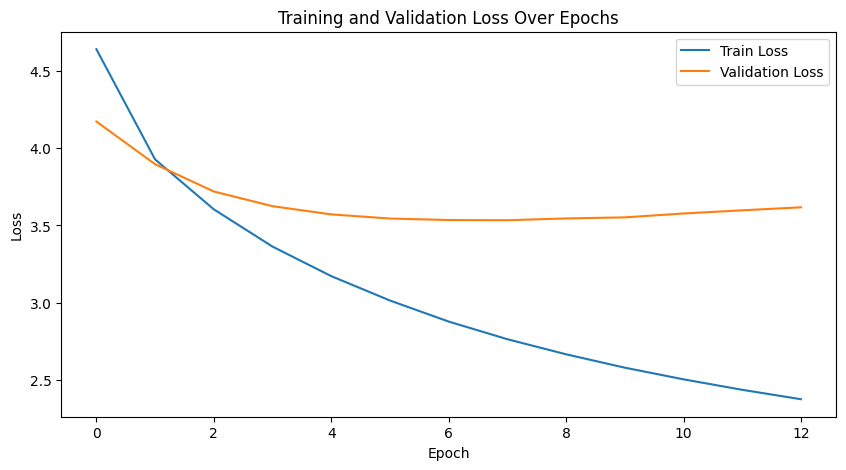

In [28]:
plot_metrics(gru_glove_trainer)

In [29]:
gru_glove_trainer.predict(gru_glove_model, data_module, return_predictions=False)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

----

Input: my two golden retrievers loved these and they kept them busy longer than other chews a bit expensive so they
will not get them often but they will get them again

Target: very good

Output: my good

Rouge: 0.5

----

Input: this is the softest best tasting licorice that i have ever eaten and i am a snob about licorice it is also 
the best value which for me is an important consideration

Target: sweetest liquorice

Output: best licorice

Rouge: 0.0

----

Input: i loved kettle chips from the moment i tried them but i felt absolutely disgusting every time i had the 
kettle brand though very tasty and crunchy they were also very oily with deep river snacks they have got the crunch
and taste without that repulsive burst of oil in your mouth with each crunch that kettle brand had i love the sweet
onion maui and mesquite bbq the jalapeno flavor does spicy justice and the rosemary olive oil is very unique for a 
chip i wish they had a sour cream and onion flavor but i love them regardless

Target: yum

Output: not

Rouge: 0.0

----

Input: i love the bbq pop chips they have a little zip to the flavor and are better than most bbq chips the 
individual bags are great for taking them with you and watching your portion size i love the convenience of the 
auto ship program i never run out

Target: bbq pop chips are yummy and convenient

Output: popchips pop chips great good

Rouge: 0.3333333432674408

----

Input: ordered and received kit in jan started brewing march drank first bottle around april bavarian hefweizen 
very good taste about percent alcohol or proof must follow directions and keep everything clean quality kit 
contained everyting to make your first brew but i have added a few things like hops bags and thermometer and extra 
bottle caps i do not recommend buying inexpensive kits i also recommend buying joy of home brewing to go along with
the kit the kit directions are basic the book has helpful tips the price i paid was better than what i would pay 
locally in this area by about i prefered new bottles as i did not want to mess with finding and cleaning bottles 
with non twist off caps extra oz bottles run about for bottles first batch figures out to about per bottle which 
includes the cost of the kit after that it is about cents a bottle as a side note i started my second batch may 
enjoy

Target: very good starter kit

Output: good good kit

Rouge: 0.5714285969734192

----

Input: lipton to go iced tea crystals are a convenient way to enjoy iced tea anywhere you have water available just
pour it in a glass or better yet a bottle and take it anywhere with you because it is decaffeinated you can enjoy 
it anytime without the worry of caffeine jitters it is also low calorie sweetened with sucralose so this might be 
your guilt free beverage

Target: very convenient and refreshing

Output: good good convenient

Rouge: 0.2857142984867096

----

Input: these are some of my dog is favorite bones the reason for stars instead of is because they leave a white 
residue wherever he eats the bone be sure you put a towel or something down if your dog eats this on something you 
care about it washes right out of a towel or blanket

Target: my dog loves these

Output: my dog loves these

Rouge: 1.0

----

Input: if you have tmj steer far away from this it is inedible never mind the taste which is completely bland and 
somewhat chalky but this is very very tough to chew for someone with tmj issues i made the mistake of looking at 
the picture and spotting nougat which really should not be that chewy i mean if i can handle a room temperature 
clif bar maybe i will microwave the ones left in the box to make them edible

Target: when they say chewy they really do mean chewy

Output: not they say to and are not

Rouge: 0.25

----

Input: this is my favorite tea i like it because it is caffeine free and i like the taste i do add a packet of 
splenda if you want to make iced tea my advice is to first brew it in a mug then add the splenda then pour it over 
ice if you brew it directly over ice then add splenda the splenda does not mix as well i paid for k cups through 
amazon this is about what i used to pay when i ordered from keurig except that i also either had to pay shipping or
order several boxes in order to get free shipping the amazon prime membership is a great deal it is worth the 
yearly fee especially at christmastime

Target: mandarin spice k cups

Output: best orance tea cups

Rouge: 0.25

----

Input: bought this at the supermarket because it was on sale very pleasantly surprised i think it tastes as good as
any standard take out joint good flavor and texture with a little kick the prep is a little more complicated than 
your average microwave meal but definitely worth it

Target: pretty good

Output: good good

Rouge: 0.5

----

Input: i like a nice pork chop from time to time and i like it breaded trouble is the breading does not always stay
put by the time the chop goes into the oven those crumbs are everywhere but on the meat shake n bake solved that 
problem with its innovative shake before baking process although you could use any breading as long as you shake 
rather than roll or dip the chops into the crumbs but these are the folks who apparently invented the process so 
one really should refrain from shaking and baking when using other brands of breading since a pork chop is pretty 
tasty with this particular mix i recommend it it made my chops nice and crispy the way i like em

Target: yummy on pork chops

Output: pretty pork chops

Rouge: 0.5714285969734192

----

Input: these are the longest lasting chews we have tried and we have tried them all much harder than greenies to 
eat up and they do not leave stains on the carpet even the green ones

Target: yum

Output: best

Rouge: 0.0

----

Input: best tasting agave so far and i have tried many of the popular store carried brands

Target: great taste

Output: best stuff

Rouge: 0.0

----

Input: this may be my favorite type of celestial seasonings so far i am a huge tea drinker and i love the sweet and
spicy blend you get from this mix plus i am a huge fan of my k cup machine so just before bed now i have a cup of 
mandarin orange spice

Target: warm and yummy

Output: love and delicious

Rouge: 0.3333333432674408

----

Input: love all the dulce gustos but not crazy about hot choc cappuccino iced cap are best sipping a hot one while 
i speak love latte too but not vanilla latte dark roast is my favorite daily thank heavens amazon offers it and 
much more affordable prices than anyone else trust me i have researched best price is on subscription and so much 
fun to receive great packing and speed always get before projected date it is almost affordable but it is part of 
my champagne taste condition i will try peach tea yum next summer

Target: addicted to my nescafe dulce gusto

Output: great to this nescafe dulce gusto

Rouge: 0.6666666865348816

----

Input: this is actually awful coffee although the packaging is lovely buying an unknown coffee is always a risky 
proposition the market is full of pretenders this stuff is over roasted and weak bad combination for a decent cup 
of coffee available at amazon try altura colombian

Target: weak all bag no kick

Output: not natural more

Rouge: 0.0

----

Input: i drink one to two of these k cups a day have been doing so for mos now love it perfect tea not bitter not 
weak i have come across the occasional k cup with a bad lid seal and it will blow the grinds into the cup then but 
i choose not to get worked up over the failure of a cent item when the others in the pack are fine edit ok i have 
to agree with the other reviewer a little more the quality of these k cups is inconsistent and they do blow grinds 
more often then they should i am still drinking this tea as much as ever as the flavor is not replicated in any 
other brand edit it is june now and this is still my main drink the k cup blowout issues seems to have been 
resolved in the last few boxes they must have fixed the problem a great tea

Target: perfect cup of tea

Output: great for of tea

Rouge: 0.5

----

Input: i have gained weight not telling you how much over the months and am putting myself on a diet these chips 
have saved me from gorging on the bad stuff becaue of their taste this product is not only healthy but it actually 
tastes the best out of all of my other possible options frito lay is the thing of the past because pop chips are in
i strongly recommend this to anybody trying to maintain or lose weight because with snacks like this you can keep 
the love handles off thank you pop chips for a successful diet go to for any more info on how they are made

Target: most delicious chips ever

Output: best sensible chips ever

Rouge: 0.5

----

Input: i love these candies however the entire case was ruined not one piece was not damaged obviously they had 
melted either prior or during shipping the chocolate was stuck to the top of the paper they are wrapped in they 
were still edible but did not quite taste the same the chocolate was gooey instead of solid even days later when 
stored at room temperature they really disappointed me so i am hoping the next case i purchase will be fresh as i 
am ordering in october a cooler month and hoping it was ruined in delivery and not the sellers storage

Target: chocolate melted

Output: melted melted melted

Rouge: 0.4000000059604645

----

Input: recently i was forced to be on a gluten and dairy free diet for a few months i have two young children and i
am busy and finding quick relatively tasty and easy gluten and dairy free options is tough i love thai food but 
never harbored any false notions that this would taste remotely authentic when was the last time you tasted 
something out of a package that tasted authentic or even remotely good for that matter also i tend to stick with 
whole foods and avoid packaged processed foods no matter how healthy as much as possible anyway i was surprised 
that i enjoyed this i still eat them and i am off the restricted diet salty yes but i love salty foods and you have
to have a microwave that can adjust it is power to most do these days and they talk about the noodles fluffing up 
which mine never did lastly it is not cheap and it is definitely a small meal but at the end of the day it is a 
tasty option for those who can not have gluten or dairy products it is actually vegan too

Target: tasty option for gluten dairy free

Output: great but for a free free

Rouge: 0.3333333432674408

----

Input: not only did of the bags arrive popped the smell of the product is enough to sending you running to the 
toilet these are soaked in water and smell of potent rotten fish i would not give this product to a starving 
homeless person they are so nasty smelling grosss

Target: rotten fish goop

Output: bad fish goop

Rouge: 0.6666666865348816

----

Input: we love our keurig coffeemaker and have tried many coffees recently discovered wolfgang puck is new line of 
coffees and are pleased with all of his we have tried this one is smooth with a great flavor no bite we would 
purchase this again

Target: great coffee

Output: great coffee

Rouge: 1.0

----

Input: i do not typically like banana flavored stuff i am not that crazy about adding bananas in my shakes but this
banana cookie bar is freakin awesome it is so delicious i share them with friends all the time and the only friend 
that did not like it just had a thing about not liking dates and the only three ingredients in this bar o goodness 
are almonds dates and unsweetened bananas thank you lara for your deliciousness in a bar just as tasty as it is 
nutritious and that is somewhat difficulat to find in ready to eat foods

Target: banana cookie goodness

Output: delicious nut

Rouge: 0.0

----

Input: first off this is a remarkable tea very strong and worth the price the only thing wrong with it is the 
wrapping the cabinet i have the boxes of tea in are completely dirty now with tea grains somehow bits and pieces 
fall through the box and the plastic wrapping that is my only complaint

Target: only thing wrong

Output: great tea to

Rouge: 0.0

----

Input: fabulous product delicious great substitute for butter and other unhealthy fats actually tastes better and 
much healthier love it on popcorn sweat potatoes unbelievable spread on whole wheat toast sprinkled with organic 
coconut sugar another great product also a great moisturizer with a wonderful aroma love it best find ever

Target: nutiva organic extra virgin coconut oil

Output: delicious coconut virgin oil

Rouge: 0.4000000059604645

----

Input: bottom line these crackers are a great snack ordering by the case saves some money compared to the charged 
locally whether plain onion or sesame i have never tried the wasabi these are a low fat reasonable calorie snack 
eaten either plain or with something on it the only sad thing is that i first ordered them in for per case

Target: great snack

Output: great cracker

Rouge: 0.5

----

Input: the convenient packs make it easy to share though you will not want to and keeps your nibbling down to a 
conscientious two cookies per snack if you are a shortbread fan then this is your heaven if you are feeling ritzy 
drizzle a little dark chocolate over them to really indulge

Target: best shortbread

Output: great shortbread

Rouge: 0.5

----

Input: i like this soup a lot it does not have the earthy taste that i have found in other boxed soups i only added
a little bbq sauce because it had no sweet to it will purchase again

Target: very good easy to use

Output: not tasty prepare

Rouge: 0.0

----

Input: my dog loves the nylabone dental dinosaur our vet recommends them for keeping the molars clean and the work 
highly recommend this product

Target: my dog loves these

Output: great dog loves these

Rouge: 0.75

----

Input: i bought a case of this as part of my canned survival food storage needless to say it tastes awful and will 
not order anymore i love molasses but for some reason i just can not stomach this i was hoping it would be a canned
comfort food for a survival situation but the only comfort would be not opening it in the first place there is so 
many more options ouch there canned bread is just not a good idea

Target: survival food

Output: not is

Rouge: 0.0

----

Input: i love these they have a great licorice taste there is only problem i eat them too fast because i like them 
so much if you like black licorice do not hesitate to buy you will like these the low calorie aspect is just a 
bonus

Target: just plain awesome

Output: great like and

Rouge: 0.0

----

Input: can get it same or lower price elsewhere do not see the point of ordering like this then the other comments 
solidify this idea

Target: trix can get it cheaper at grocery store

Output: price say walmart store

Rouge: 0.1666666716337204

----

Input: this is one of the best seasonings i have ever had it may be named cajun but it is not really that hot it 
has a good blend of spices i use it in everything from sprinkling a little bit on top of my nachos and putting it 
in my ground beef for burgers it is also excellent as a rub on steaks and chicken

Target: one of the best seasonings ever made

Output: best of the best

Rouge: 0.5454545617103577

----

Input: anyone who has a child that refuses veggies should try this it is a great combo of fruit and veggies and so 
easy to feed to older babies my daughter feeds herself and no mess it is great for on the go love them

Target: love the medley so healthy

Output: great it medley so

Rouge: 0.4444444477558136

----

Input: this is a great product for baking my only complaint is that some of the cans arrive very dented

Target: poppy seed filling

Output: great flour

Rouge: 0.0

----

Input: this whole wheat pasta has delicious taste it is not easy to find in stores around but from time to time 
whole foods not far from home has it the safest way not to run out of orzo is to order from amazon i am glad i 
found this source of orzo

Target: delicious orzo

Output: great with

Rouge: 0.0

----

Input: bought this to add to a recipe by jason schiffer for a maple manhattan it is a great bitters and played 
really well with the bourbon and maple syrup i was using great product as with any bottle of bitters oz is going to
last you a long long time so this is a great value as well i do not think you can go wrong with any of the fee 
brothers bitters have fun with them and experiment

Target: add it to your manhattan

Output: great water is the manhattan

Rouge: 0.20000000298023224

----

Input: i love kettle chips and i love spicy food this is decently spicy but i do not think the flavor is that great
you definitely taste the vinegar in these which i do not like i want the vinegar taste to be mild and subtle but it
is a bit strong for me it is not overwhelming just not how i like my buffalo flavor

Target: meh

Output: too

Rouge: 0.0

----

Input: bought cans showed up dented stay away this is just a clearing house for their damaged goods save your money

Target: dented cans

Output: dented cans

Rouge: 1.0

----

Input: omg i was at a lounge with my partner and they suggested that we try this sauce with the food we ordered 
this sauce was sooo delicious i am going to buy this product a s a p amd put it on my ribs you have to try it if 
you are a spicy eater try this

Target: this is great

Output: delicious is the

Rouge: 0.3333333432674408

Rouge avg: 0.33754509687423706

## Transformer

In [45]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout, maxlen = 5000):
        super(PositionalEncoding, self).__init__()

        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


###

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size, embedding=None):
        super(TokenEmbedding, self).__init__()

        if embedding is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding, padding_idx=PAD_IDX, freeze=True)
        else:
          self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)

        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long())


####
class Seq2SeqTransformer(pl.LightningModule):
    def __init__(self,
                 num_encoder_layers,
                 num_decoder_layers,
                 emb_size,
                 nhead,
                 src_vocab_size,
                 tgt_vocab_size,
                 learning_rate,
                 vocab,
                 dim_feedforward=512,
                 dropout=0.5,
                 embedding=None):
        super(Seq2SeqTransformer, self).__init__()
        self.learning_rate = learning_rate
        self.vocab = vocab

        self.criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

        self.transformer = nn.Transformer(
            d_model=emb_size, # the number of expected features in the encoder/decoder inputs
            nhead=nhead, # the number of heads in the multiheadattention models ()
            num_encoder_layers=num_encoder_layers, # the number of sub-encoder-layers in the encoder
            num_decoder_layers=num_decoder_layers, # the number of sub-decoder-layers in the decoder
            dim_feedforward=dim_feedforward, # the dimension of the feedforward network model
            dropout=dropout, # the dropout value
        )

        for p in self.transformer.parameters():
          if p.dim() > 1:
              nn.init.xavier_uniform_(p)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size, embedding=embedding)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size, embedding=embedding)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

        if embedding is not None:
            self.src_tok_emb.embedding.weight.data.copy_(embedding)
            self.tgt_tok_emb.embedding.weight.data.copy_(embedding)
            self.src_tok_emb.embedding.weight.requires_grad = False
            self.tgt_tok_emb.embedding.weight.requires_grad = False

    def forward(self,
                src,
                trg,
                src_mask,
                tgt_mask,
                src_padding_mask,
                tgt_padding_mask,
                memory_key_padding_mask):

        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))

        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)

        return self.generator(outs)

    def encode(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

    def shared_step(self, batch, batch_idx):
        inputs, targets = batch

        # THIS TRANSFORMER WORKS WITH [SEQ_LEN, BATCH_SIZE], NOT [BATCH_SIZE, SEQ_LEN]
        inputs = inputs.permute(1,0)
        targets = targets.permute(1,0)

        tgt_input = targets[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(inputs, tgt_input, device=self.device)
        tgt_out = targets[1:, :]

        preds = self(inputs, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
        preds = preds.reshape(-1, preds.shape[-1])
        tgt_out = tgt_out.reshape(-1)
        loss = self.criterion(preds, tgt_out)

        return loss

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

def generate_square_subsequent_mask(sz, device='cpu'):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt, device='cpu'):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, device)

    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


#######
INPUT_DIM = basic_vocab_size
OUTPUT_DIM = basic_vocab_size
EMB_DIM = glove_embed_dim
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 5e-4
N_HEADS = 8


model_transf = Seq2SeqTransformer(
    num_encoder_layers=ENC_LAYERS,
    num_decoder_layers=DEC_LAYERS,
    emb_size=EMB_DIM,
    nhead=N_HEADS,
    src_vocab_size=INPUT_DIM,
    tgt_vocab_size=OUTPUT_DIM,
    learning_rate=LEARNING_RATE,
    vocab=data_module.vocab,
    embedding=glove_embedding,
    dropout=0.5
)

####

PATIENCE = 3
NUM_EPOCHS = 30

early_stopping_cb = EarlyStopping(monitor="val_loss", mode="min", patience=PATIENCE)

logger = CSVLogger(save_dir=f'outputs-bc', name='transformer')

transf_trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=[early_stopping_cb, RichProgressBar(refresh_rate=10)],
    accelerator="auto",
    devices="auto",
    logger=logger
)

start_time = time.time()
transf_trainer.fit(model_transf, data_module)
elapsed_time = (time.time() - start_time) / 60
print(f'Training time: {elapsed_time:.2f} minutes')


INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ vocab               │ Vocab              │      0 │ train │
│ 1 │ criterion           │ CrossEntropyLoss   │      0 │ train │
│ 2 │ transformer         │ Transformer        │  2.7 M │ train │
│ 3 │ generator           │ Linear             │  9.6 M │ train │
│ 4 │ src_tok_emb         │ TokenEmbedding     │  9.6 M │ train │
│ 5 │ tgt_tok_emb         │ TokenEmbedding     │  9.6 M │ train │
│ 6 │ positional_encoding │ PositionalEncoding │      0 │ train │
└───┴─────────────────────┴────────────────────┴────────┴───────┘

Trainable params: 12.3 M                                                                                           
Non-trainable params: 19.1 M                                                                                       
Total params: 31.4 M                                                                                               
Total estimated model params size (MB): 125                                                                        
Modules in train mode: 88                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched 
key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(

Training time: 3.36 minutes


In [46]:
 # function to generate output sequence using greedy algorithm
def greedy_decode(_model, src, src_mask, max_len, start_symbol, device):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = _model.encode(src, src_mask)

    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)

    for i in range(max_len-1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(device)
        out = _model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = _model.generator(out[:, -1])
        prob = torch.softmax(prob, dim=-1)
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)

        if next_word == EOS_IDX:
            break

    return ys


# actual function to translate input sentence into target language
def summarize(src, _model, _data_module, device):
    # src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    src = src.view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        _model,  src, src_mask, max_len=num_tokens + 5, start_symbol=SOS_IDX, device=device).flatten()

    # print('target tokens: ', tgt_tokens[0].item(), '---')

    return tgt_tokens.cpu().detach()

def evaluate(_model, _data_module):
  counter = 0
  rouge_avg = 0
  _rougeScore = ROUGEScore(rouge_keys='rougeL', tokenizer=word_tokenize)

  for src, tgt in _data_module.val_dataloader():
    for i in range(len(src)): # iterate through the batch items
      if counter > 40:
        break

      target_summary = indexes_2_text(tgt[i], data_module.vocab, remove_specials=True)
      pred_summary = indexes_2_text(summarize(src[i], _model, data_module, device=transf_trainer.model.device), _data_module.vocab, remove_specials=True)

      rouge = _rougeScore(target_summary, pred_summary)['rougeL_fmeasure'].item()

      print('TEXT: ', indexes_2_text(src[i], data_module.vocab, remove_specials=True))
      print('TARGET:', target_summary)
      print('PRED:', pred_summary)
      print('ROUGE:', rouge)
      print('----')
      rouge_avg += rouge

      counter += 1


  print('ROUGE AVG:', rouge_avg / counter)


evaluate(model_transf, data_module)

TEXT:  i have purchased this tea before and just love it but my latest purchase have inferior bags they break no matter how carefully you place them into the hot water or pour over the former bags were not the flow thru type and never broke these flow thru bags are very thin and cheaply made the tea still tastes great
TARGET: inferior bags
PRED: not as advertised
ROUGE: 0.0
----
TEXT:  madhave blonde coconut sugar put in my tea and black specks floated to the top not bugs just unidentified black specks of something not very appealing tried it again in a cup of coffee got a sliver of something that looked like a hair thin toothpick realized it must be one of the stringy hair like parts of the outside of the coconut then i got another spit it out and dumped the coffee i am back to xyletol and i am throwing out worth of coconut sugar this was one bad buy
TARGET: yucky coconut sugar
PRED: not bad
ROUGE: 0.0
----
TEXT:  the zip lock packaging makes it easy and convenient to use and store wi

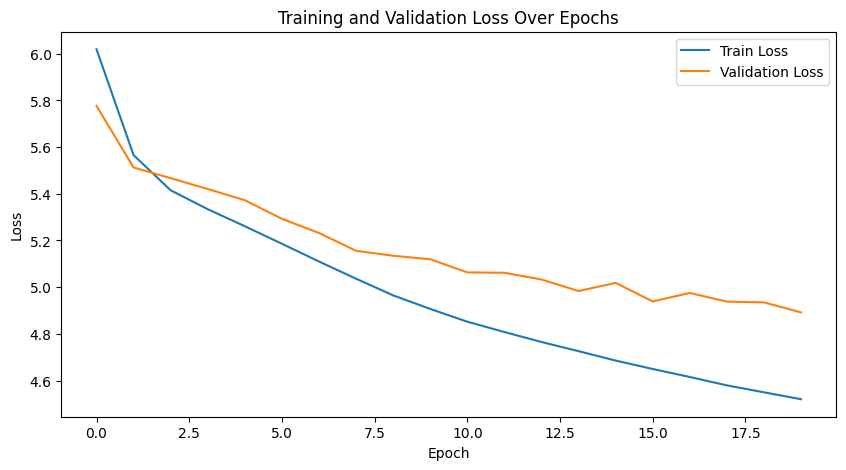

In [48]:
plot_metrics(transf_trainer)
